# CIFAR-10 Image Classification
In this project, we classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. We preprocess the images, then train a convolutional neural network on all the samples. The images are normalized and the labels one-hot encoded.  That is an introduction to integrate convolution, max pooling, dropout, and fully connected layers. At the end, we get to see the neural network's predictions on sample images.

This is a project executed during Udacity Deep Learning Foundation.

## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


## Explore the Data
The dataset is broken into batches to prevent the machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  We can play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

"What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these help us preprocess the data and end up with better predictions.


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


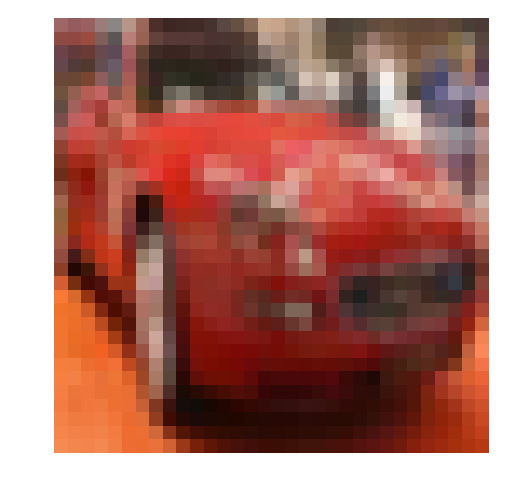

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [3]:
# Further exploration
batch_id = 1
sample_id = 5
features, labels = helper.load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
label_names = helper._load_label_names()

print('features shape: ', features.shape, 'Type:', type(features))
print('labels shape: ', len(labels), 'Type:', type(labels))
print('labels name shape: ', len(label_names), 'Type:', type(label_names))

features shape:  (10000, 32, 32, 3) Type: <class 'numpy.ndarray'>
labels shape:  10000 Type: <class 'list'>
labels name shape:  10 Type: <class 'list'>


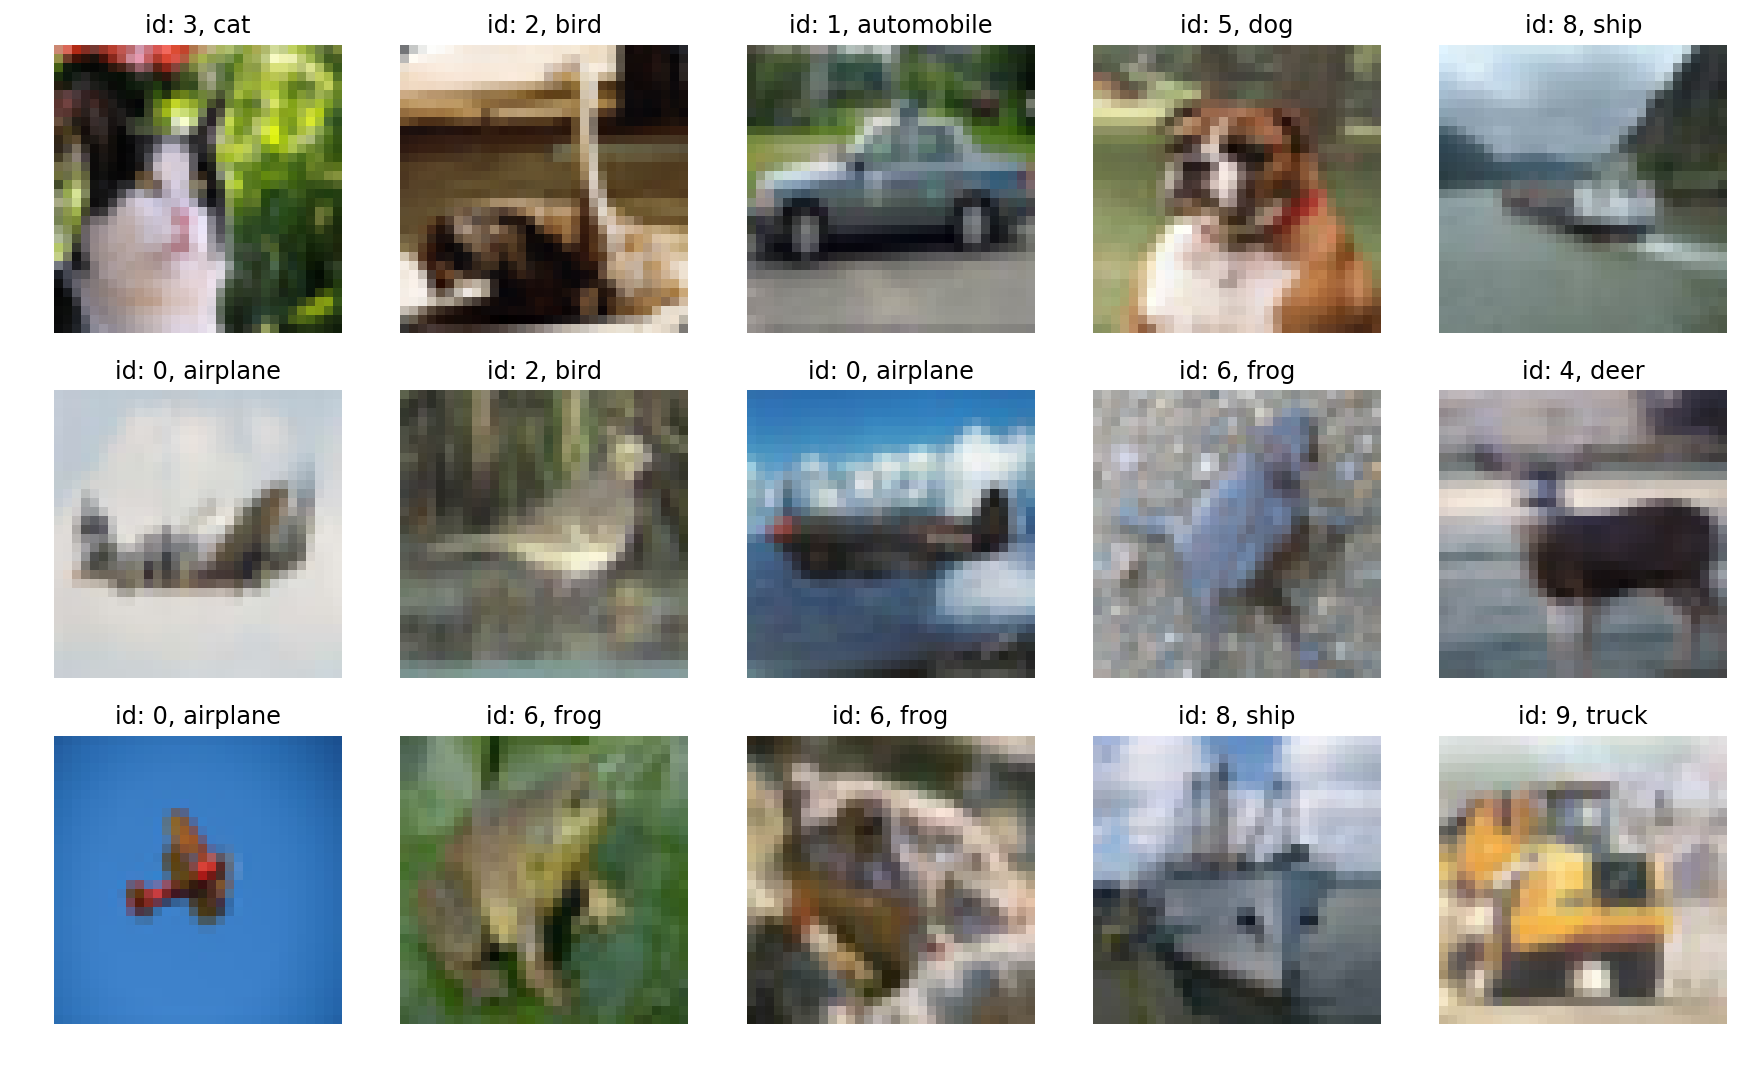

In [4]:
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

#  Plotting samples of the images
def plotsignal(images, labels, label_names, nrows=1, ncols=1, cmap=None, prefix_label = 'label:'):
    """
    Plot images in a subplot arrangement.
    images = 4D array containing raw pixel data of the images, (num examples, width, height, channels)
    labels = 1D array containing the label/class id of the image
    label_names = 1D array containing the label names for each class
    nrows = numbers of rows in the image plot arrangement
    ncols = numbers of columns in the image plot arrangement
    prefix_label = prefix label to show on top of images
    """
    scalesize = 3*nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(scalesize/nrows, scalesize/ncols))
    if (nrows != 1) and (ncols != 1): # Take care of error in case nrows/ncols = 1
        axarr = axarr.ravel()
    if (nrows == 1) and (ncols == 1): # Take care of error in case both nrows/ncols = 1
        index = np.random.randint(0, len(images))
        image = images[index].squeeze()
        axarr.axis('off')
        axarr.imshow(image, cmap=cmap)
        axarr.set_title(prefix_label + ' ' + labels[index])
    else:
        for i in range(nrows*ncols):
            index = np.random.randint(0, len(images))
            image = images[index].squeeze()
            axarr[i].axis('off')
            axarr[i].imshow(image, cmap=cmap)
            axarr[i].set_title(prefix_label + ' ' + str(labels[index]) + ', ' + label_names[labels[index]])

nrows = 3 # change it here the way you want, 0 will give error
ncols = 5 # change it here the way you want, 0 will give error
plotsignal(features, labels, label_names, nrows, ncols, cmap=None, prefix_label = 'id:')

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


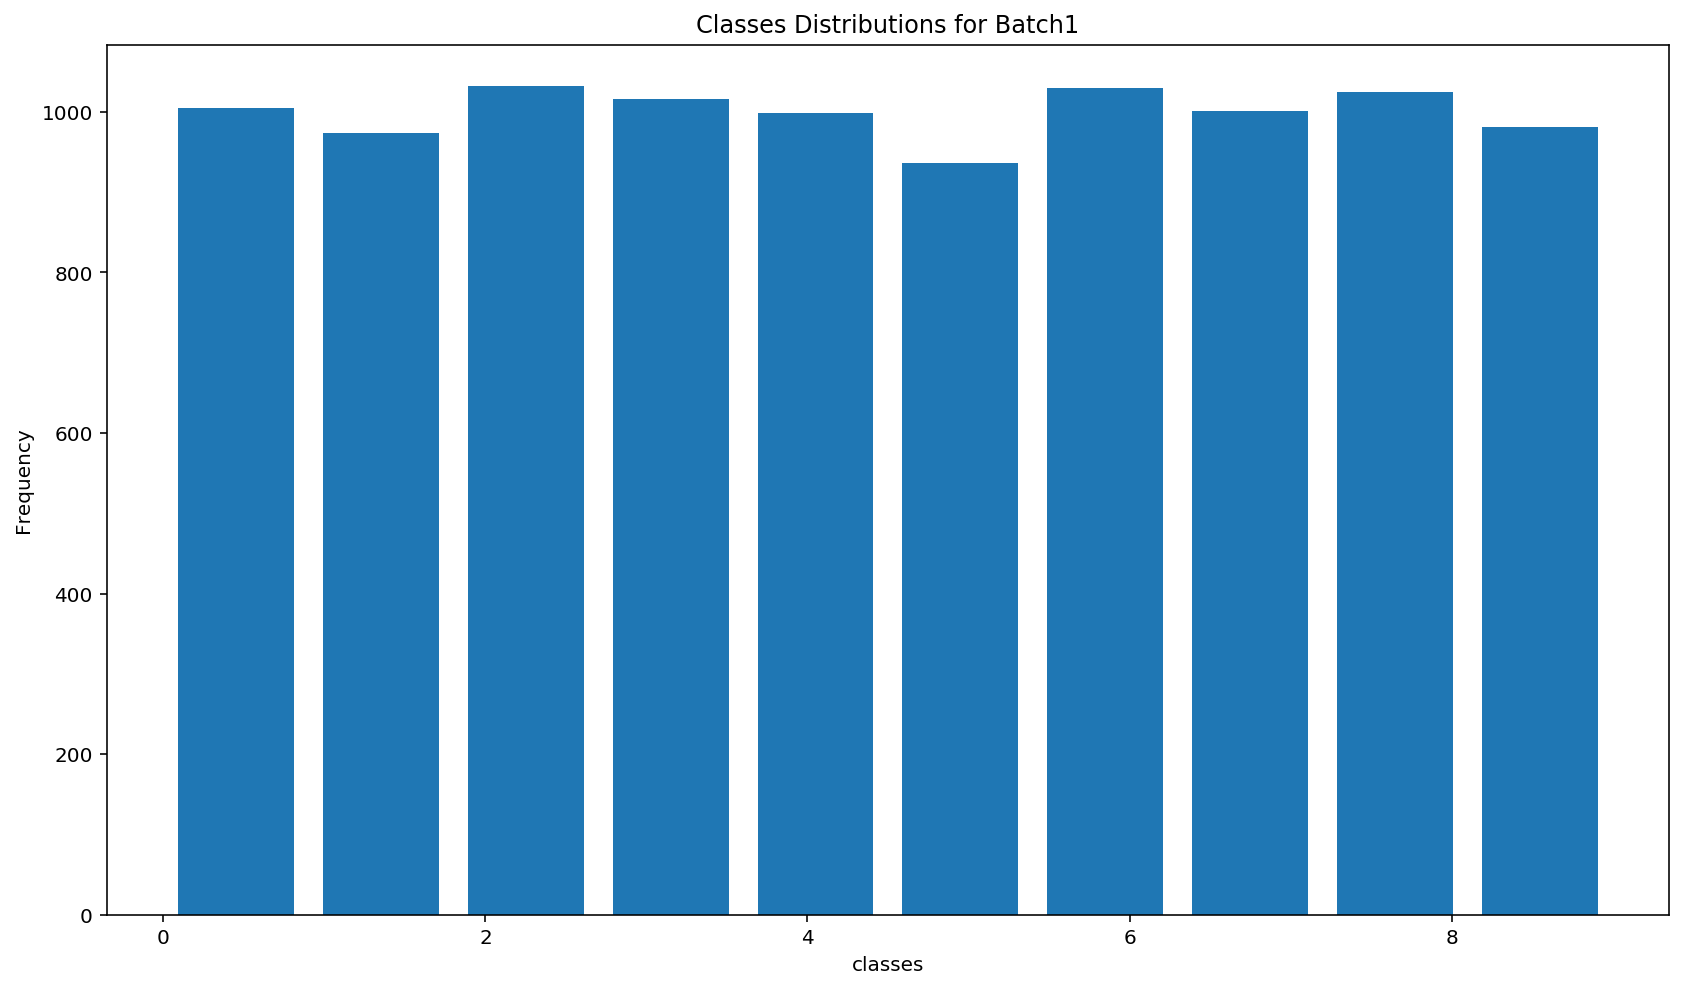

In [5]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "14, 8" # or  whatever you want

# Plotting the count of each sign
fig, ax = plt.subplots()
import seaborn as sns
n, bins, patches = plt.hist(x=labels, bins=len(label_names), rwidth=0.8)
ax.set_xlabel('classes')
ax.set_ylabel('Frequency')
ax.set_title('Classes Distributions for Batch' + str(batch_id))

## Preprocess Functions
### Normalize
In the cell below, we implement the `normalize` function to take in image data, `x`, and return it as a normalized Numpy array. The values are in the range of 0 to 1, inclusive.  The return object is the same shape as `x`.

In [ ]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """

    # Normalizing on interval of [0,1]
    x = x / 255.
    
    return x


### One-hot encode
Just like the previous code cell, here we are implementing a function for preprocessing.  This time, we implement the `one_hot_encode` function. The input, `x`, are a list of labels.  The function returns a list of labels as One-Hot encoded Numpy array.  The possible values for labels are 0 to 9. The one-hot encoding function returns the same encoding for each value between each call to `one_hot_encode`. 

In [ ]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
        
    n_labels = 10
    targets = x
    
    #empty one-hot matrix
    ohm = np.zeros((len(targets), n_labels))
    
    #set target idx to 1
    ohm[np.arange(len(targets)), targets] = 1
    

    return ohm


#Verify One_hot_Encode
'''
test_shape = np.random.choice(range(35))
print('No. of samples: ', test_shape)
test_numbers = np.random.choice(range(10), test_shape)
print('List of samples lables: ', test_numbers)
one_hot_out = one_hot_encode(test_numbers)
print('1st sample one-hot with id ' + str(test_numbers[0]) + ' enhanced: ', one_hot_out[0])
print('2nd sample one-hot with id ' + str(test_numbers[1]) + ' enhanced: ', one_hot_out[1])
'''

### Randomize Data
As we saw from exploring the data above, the order of the samples are randomized.  It doesn't hurt to randomize it again, but we don't need to for this dataset.

## Preprocess all the data and save it
Running the code cell below will preprocess all the CIFAR-10 data and save it to file. The code below also uses 10% of the training data for validation.

In [8]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Check Point
This is the first checkpoint.  If we ever decide to come back to this notebook or have to restart the notebook, we can start from here.  The preprocessed data has been saved to disk.

In [9]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Build the network
For the neural network, we build each layer into a function.  

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability.

In [ ]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    
    # Features
    x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]), name='x')

    return x


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    
    # Labels
    y = tf.placeholder(tf.int32, (None, n_classes), name='y')

    return y


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    
    # Dropout keep percentage parameter
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')

    return keep_prob


### Convolution and Max Pooling Layer
Convolution layers have a lot of success with images. For this code cell, we implement the function `conv2d_maxpool` to apply convolution then max pooling.


In [ ]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    
    # Get shape of the tensor
    tensor_shape = x_tensor.get_shape().as_list()
    #print('tensor_shape as list:', tensor_shape)

    # Weights & Biases
    weights = tf.Variable(tf.truncated_normal(shape=(conv_ksize[0],conv_ksize[1],tensor_shape[3],conv_num_outputs),
                                              mean = 0, stddev = 0.1))    
    biases = tf.Variable(tf.zeros(conv_num_outputs))
    #print('weights shape:', weights.get_shape())
    #print('biases shape:', biases.get_shape())
    
    
    # Convolution
    #print('x_tensor shape:', x_tensor.get_shape())
    x_tensor = tf.nn.conv2d(x_tensor,
                            weights,
                            strides=[1, conv_strides[0], conv_strides[1], 1],
                            padding='SAME')    
    #print('conv2d shape:', x_tensor.get_shape())
    
    # Add bias
    x_tensor = tf.nn.bias_add(x_tensor, biases)
    #print('add b shape:', x_tensor.get_shape())
    
    # Add nonlinear activation, ReLu
    x_tensor = tf.nn.relu(x_tensor)
    #print('relu shape:', x_tensor.get_shape())
    
    # Sampling with Max Pooling
    x_tensor = tf.nn.max_pool(x_tensor,
                              ksize=[1, pool_ksize[0], pool_ksize[1], 1],
                              strides=[1, pool_strides[0], pool_strides[1], 1],
                              padding='SAME')    
    #print('max pool shape:', x_tensor.get_shape())
    
    
    return x_tensor 


### Convolution Layer
And now, only Convolution without max pooling.

In [12]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    : return: A tensor that represents convolution of x_tensor
    """
    # TODO: Implement Function
    
    # Get shape of the tensor
    tensor_shape = x_tensor.get_shape().as_list()
    #print('tensor_shape as list:', tensor_shape)

    # Weights & Biases
    weights = tf.Variable(tf.truncated_normal(shape=(conv_ksize[0],conv_ksize[1],tensor_shape[3],conv_num_outputs),
                                              mean = 0, stddev = 0.1))    
    biases = tf.Variable(tf.zeros(conv_num_outputs))
    #print('weights shape:', weights.get_shape())
    #print('biases shape:', biases.get_shape())
    
    
    # Convolution
    #print('x_tensor shape:', x_tensor.get_shape())
    x_tensor = tf.nn.conv2d(x_tensor,
                            weights,
                            strides=[1, conv_strides[0], conv_strides[1], 1],
                            padding='SAME')    
    #print('conv2d shape:', x_tensor.get_shape())
    
    # Add bias
    x_tensor = tf.nn.bias_add(x_tensor, biases)
    #print('add b shape:', x_tensor.get_shape())
    
    # Add nonlinear activation, ReLu
    x_tensor = tf.nn.relu(x_tensor)
    #print('relu shape:', x_tensor.get_shape())
   
    
    return x_tensor 

### Flatten Layer
`flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output is the shape (*Batch Size*, *Flattened Image Size*).

In [ ]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    
    # Get shape of the tensor
    tensor_shape = x_tensor.get_shape().as_list() 
    
    # Get the flatten dimension, which is the product of all dim except the 1st (batch)
    dim = np.prod(tensor_shape[1:])
    
    # Reshape it accordingly
    x_tensor = tf.reshape(x_tensor, [-1, dim]) 
    
    return x_tensor


### Fully-Connected Layer
`fully_conn` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

In [ ]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    
    # Get shape of the tensor
    tensor_shape = x_tensor.get_shape().as_list()
    
    # Weights & Biases
    weights = tf.Variable(tf.truncated_normal(shape=(tensor_shape[1],num_outputs), mean = 0, stddev = 0.1))   
    biases = tf.Variable(tf.zeros(num_outputs))
    
    # Linear operation
    x_tensor = tf.add(tf.matmul(x_tensor, weights), biases)
    
    # Add nonlinear activation, ReLu
    x_tensor = tf.nn.relu(x_tensor)


    return x_tensor


### Output Layer
`output` function applies a fully connected layer to `x_tensor` with the shape (*Batch Size*, *num_outputs*). 

**Note:** Activation, softmax, or cross entropy are **not** applied to this.

In [ ]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    
    # Get shape of the tensor
    tensor_shape = x_tensor.get_shape().as_list()
    
    # Weights & Biases
    weights = tf.Variable(tf.truncated_normal(shape=(tensor_shape[1],num_outputs), mean = 0, stddev = 0.1))   
    biases = tf.Variable(tf.zeros(num_outputs))
    
    # Linear operation
    x_tensor = tf.add(tf.matmul(x_tensor, weights), biases)
    
    return x_tensor


### Creating the Convolutional Model
We can play with all the functions we have created to assemble the model the way we want to. We could use convolutions with and without max pooling, flatten, fully connected and the output functions. Look at the cell below on the function `conv_net` to see what I have ended up with. 

I have started with tradidional architectures, alternating convolution and max-pooling layers followed
by a small number of fully connected layers, but end up with all conv net model inspired by:

"STRIVING FOR SIMPLICITY: THE ALL CONVOLUTIONAL NET"
https://arxiv.org/pdf/1412.6806.pdf

This model does not use fully connected layers before the classifier, it uses 1x1 convolutions instead:
>*"...This leads to predictions of object classes at different positions which can then simply be averaged over the whole image. This scheme was first described by Lin et al. (2014) and further regularizes the network as the one by one convolution has much less parameters than a fully connected layer..."*

In [ ]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    node_out1=36
    node_out2=2*node_out1
    
    # Input 32x32x3
    l0 = x
    print('l0 shape:', l0.get_shape())
    
    # Input 32x32x3. Output 16x16x80
    l1 = conv2d(x_tensor=l0, conv_num_outputs=node_out1, conv_ksize=[3,3], conv_strides=[1,1])  
    l1 = conv2d_maxpool(x_tensor=l1, conv_num_outputs=node_out1, conv_ksize=[3,3],
                   conv_strides=[1,1], pool_ksize=[3,3], pool_strides=[2,2])
    l1 = tf.nn.dropout(l1, keep_prob)
    print('l1 shape:', l1.get_shape())
    
    # Input 16x16x80. Output 8x8x160 
    l2 = conv2d(x_tensor=l1, conv_num_outputs=node_out2, conv_ksize=[3,3], conv_strides=[1,1])
    l2 = conv2d_maxpool(x_tensor=l2, conv_num_outputs=node_out2, conv_ksize=[3,3],
                   conv_strides=[1,1], pool_ksize=[3,3], pool_strides=[2,2])
    l2 = tf.nn.dropout(l2, keep_prob)
    print('l2 shape:', l2.get_shape())
    
    # Input 8x8x160. Output 4x4x160
    l3 = conv2d_maxpool(x_tensor=l2, conv_num_outputs=node_out2, conv_ksize=[3,3],
                   conv_strides=[1,1], pool_ksize=[2,2], pool_strides=[2,2])
    print('l3 shape:', l3.get_shape())
    
    # Input 4x4x160. Output 4x4x160
    l4 = conv2d(x_tensor=l3, conv_num_outputs=node_out2, conv_ksize=[3,3], conv_strides=[1,1])
    print('l4 shape:', l4.get_shape())
    
    # Input 4x4x160. Output 4x4x160
    l5 = conv2d(x_tensor=l4, conv_num_outputs=node_out2, conv_ksize=[1,1], conv_strides=[1,1])
    print('l5 shape:', l5.get_shape())
    
    # Input 4x4x160. Output 4x4x10 
    l6 = conv2d(x_tensor=l5, conv_num_outputs=10, conv_ksize=[1,1], conv_strides=[1,1])
    print('l6 shape:', l6.get_shape())
    
    # Input 4x4x10. Output 1x1x10     
    l6 = tf.nn.avg_pool(l6, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME') 
    print('l6 avg shape:', l6.get_shape())
    
    # Input 1x1x10. Output 1x10 
    logits = flatten(x_tensor=l6)
    print('logits shape:', logits.get_shape())

    return logits


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


## Train the Neural Network
### Single Optimization
`train_neural_network` function is created to do a single optimization.  The optimization uses `optimizer` to optimize in `session` with a `feed_dict` of the following:
* `x` for image input
* `y` for labels
* `keep_prob` for keep probability for dropout

This function is called for each batch, so `tf.global_variables_initializer()` has already been called.

Note: Nothing needs to be returned. This function is only optimizing the neural network.

In [ ]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob: keep_probability})
    
    pass



### Show Stats
The function `print_stats` prints losses and accuracies.  It uses the global variables `valid_features` and `valid_labels` to calculate validation accuracy.  keep probability is `1.0` to calculate the validation loss and validation accuracy.

In [18]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    
    train_loss = session.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 0.5})
    val_loss = session.run(cost, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})
    train_accuracy = session.run(accuracy, feed_dict={x: feature_batch, y: label_batch, keep_prob: 0.5})
    val_accuracy = session.run(accuracy, feed_dict={x: valid_features, y: valid_labels, keep_prob: 1.0})

    print("val_loss: "+str(val_loss)[:5]+" val_accuracy: "+str(val_accuracy)[:5] \
         +" train_accuracy: "+str(train_accuracy)[:5])
    
    
    return train_loss, val_loss, train_accuracy, val_accuracy

### Hyperparameters
* `epochs` to the number of iterations until the network stops learning or start overfitting
* `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* `keep_probability` to the probability of keeping a node using dropout

In [19]:
# Tune Parameters
epochs = 60
batch_size = 128
keep_probability = 0.5

### Train on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, let's use a single batch. This should save time while you iterate on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, we run the model on all the data in the next section.

In [20]:
print('Checking the Training on a Single Batch...')
log = {'train_accuracy':[], 'val_accuracy':[]}
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        train_loss, val_loss, train_accuracy, val_accuracy = print_stats(sess, batch_features,
                                                                         batch_labels, cost, accuracy)
        
        log['train_accuracy'].append(train_accuracy)
        log['val_accuracy'].append(val_accuracy)


Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  val_loss: 2.225 val_accuracy: 0.187 train_accuracy: 0.125
Epoch  2, CIFAR-10 Batch 1:  val_loss: 2.101 val_accuracy: 0.258 train_accuracy: 0.25
Epoch  3, CIFAR-10 Batch 1:  val_loss: 2.007 val_accuracy: 0.256 train_accuracy: 0.175
Epoch  4, CIFAR-10 Batch 1:  val_loss: 1.807 val_accuracy: 0.366 train_accuracy: 0.425
Epoch  5, CIFAR-10 Batch 1:  val_loss: 1.705 val_accuracy: 0.396 train_accuracy: 0.4
Epoch  6, CIFAR-10 Batch 1:  val_loss: 1.630 val_accuracy: 0.435 train_accuracy: 0.625
Epoch  7, CIFAR-10 Batch 1:  val_loss: 1.569 val_accuracy: 0.457 train_accuracy: 0.65
Epoch  8, CIFAR-10 Batch 1:  val_loss: 1.514 val_accuracy: 0.487 train_accuracy: 0.65
Epoch  9, CIFAR-10 Batch 1:  val_loss: 1.511 val_accuracy: 0.480 train_accuracy: 0.525
Epoch 10, CIFAR-10 Batch 1:  val_loss: 1.448 val_accuracy: 0.505 train_accuracy: 0.575
Epoch 11, CIFAR-10 Batch 1:  val_loss: 1.392 val_accuracy: 0.523 train_accuracy: 0.575
Epoch

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


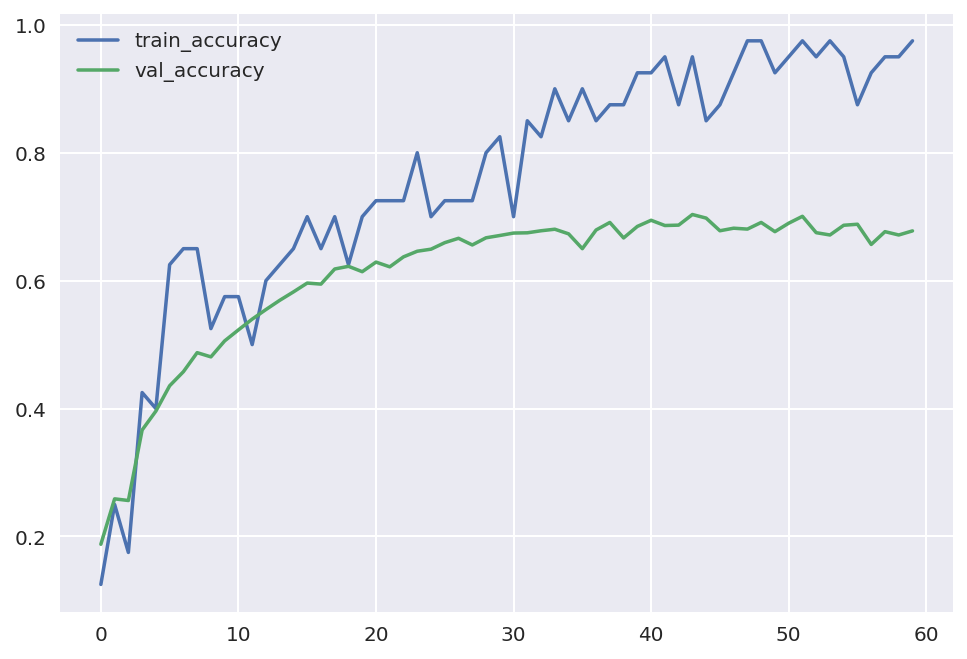

In [21]:
# Visualize log
plt.plot(log['train_accuracy'], label='train_accuracy')
plt.plot(log['val_accuracy'], label='val_accuracy')
plt.legend()

In [24]:
# Tune Parameters
epochs = 50
batch_size = 128
keep_probability = 0.5

### Fully Train the Model
Now that we got a good accuracy with a single CIFAR-10 batch, let's try it with all five batches.

In [25]:
save_model_path = './image_classification'

print('Training...')
log = {'train_accuracy':[], 'val_accuracy':[]}
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            train_loss, val_loss, train_accuracy, val_accuracy = print_stats(sess, batch_features, batch_labels,
                                                                             cost, accuracy)
            log['train_accuracy'].append(train_accuracy)
            log['val_accuracy'].append(val_accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  val_loss: 2.185 val_accuracy: 0.177 train_accuracy: 0.225
Epoch  1, CIFAR-10 Batch 2:  val_loss: 2.094 val_accuracy: 0.234 train_accuracy: 0.175
Epoch  1, CIFAR-10 Batch 3:  val_loss: 1.939 val_accuracy: 0.322 train_accuracy: 0.325
Epoch  1, CIFAR-10 Batch 4:  val_loss: 1.816 val_accuracy: 0.366 train_accuracy: 0.225
Epoch  1, CIFAR-10 Batch 5:  val_loss: 1.670 val_accuracy: 0.414 train_accuracy: 0.45
Epoch  2, CIFAR-10 Batch 1:  val_loss: 1.563 val_accuracy: 0.414 train_accuracy: 0.475
Epoch  2, CIFAR-10 Batch 2:  val_loss: 1.479 val_accuracy: 0.445 train_accuracy: 0.475
Epoch  2, CIFAR-10 Batch 3:  val_loss: 1.456 val_accuracy: 0.469 train_accuracy: 0.45
Epoch  2, CIFAR-10 Batch 4:  val_loss: 1.378 val_accuracy: 0.505 train_accuracy: 0.425
Epoch  2, CIFAR-10 Batch 5:  val_loss: 1.346 val_accuracy: 0.517 train_accuracy: 0.45
Epoch  3, CIFAR-10 Batch 1:  val_loss: 1.339 val_accuracy: 0.497 train_accuracy: 0.625
Epoch  3, CIFAR-10 Batch 2:  val_l

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


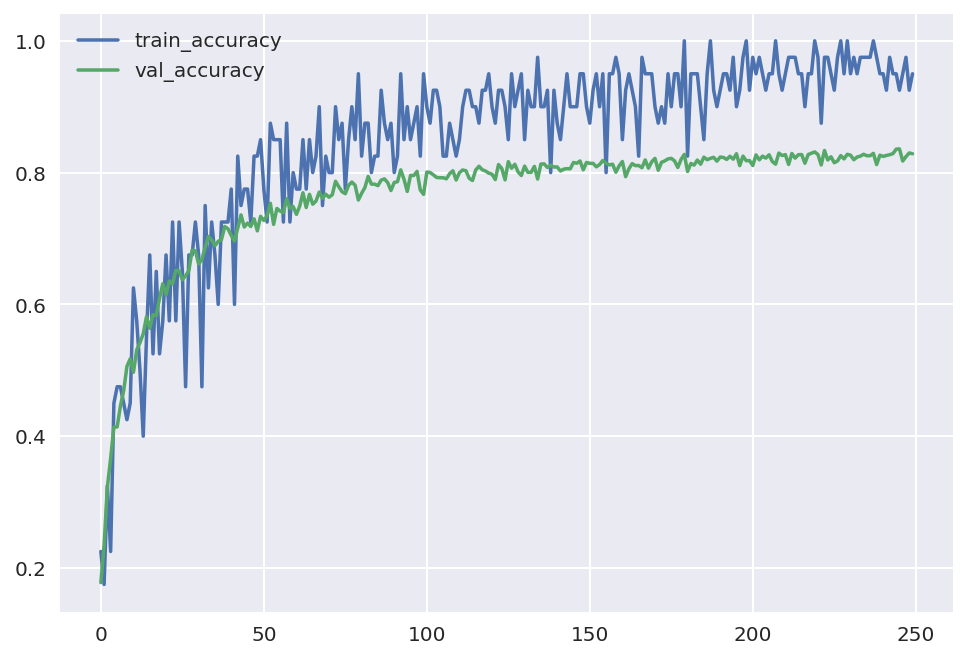

In [26]:
# Visualize log
plt.plot(log['train_accuracy'], label='train_accuracy')
plt.plot(log['val_accuracy'], label='val_accuracy')
plt.legend()

# Checkpoint
The model has been saved to disk.
## Test Model
Test your model against the test dataset.  This is the final accuracy.

Testing Accuracy: 0.8254549050632911



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


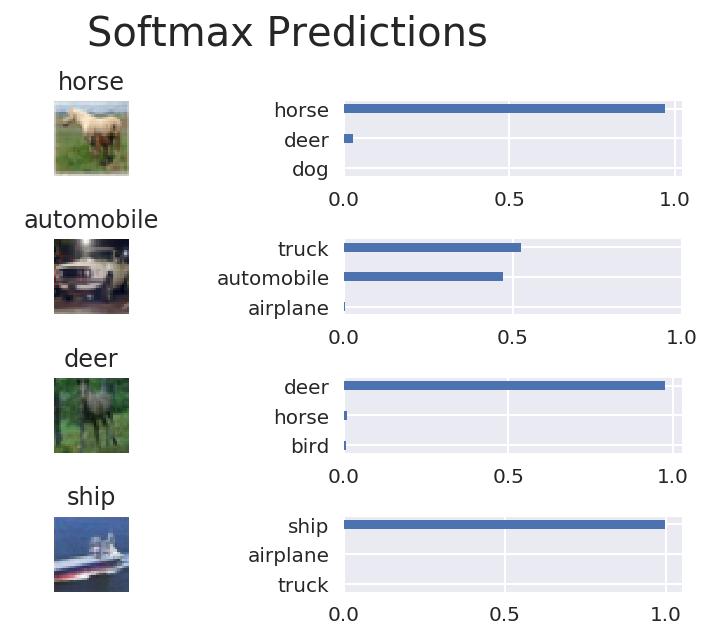

In [27]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_training.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
50% isn't bad for a simple CNN.  Pure guessing would get you 10% accuracy. However, people are getting scores [well above 70%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).  That's because we haven't used all there is to know about neural networks. It would require to apply a few more sophisticated techniques such as more advanced preprocessing like data augumentation, more regularization such as L2, we apply spatial transformers, learning decay, etc.

**So far we got a really good 82.5% using simple CNN!**
